In [10]:
!pip install rdt
#this lines only needed to run with google colab
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append("/content/drive/My Drive/CTGAN/CTGAN")#save the git project in CTGAN directory and the git project name is CTGAN (do not forget)
#all of this are saved in google drive of my university account(the directory CTGAN CTGAN is in it)
#this lines only needed to run with google colab

import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import *

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
from ctgan import load_demo
data = load_demo()

categorical_features = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
]

data = data.drop(columns=categorical_features)

In [12]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features = []
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.812


In [14]:
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
16465,39,188571,7,0,0,40
5625,54,105010,13,0,0,40
30273,32,156464,9,0,1902,50
3136,45,32172,10,0,0,50
4521,60,146674,6,0,0,40
...,...,...,...,...,...,...
32511,25,514716,13,0,0,40
5192,32,207668,13,15024,0,45
12172,27,104457,13,0,0,40
235,59,268700,9,0,0,40


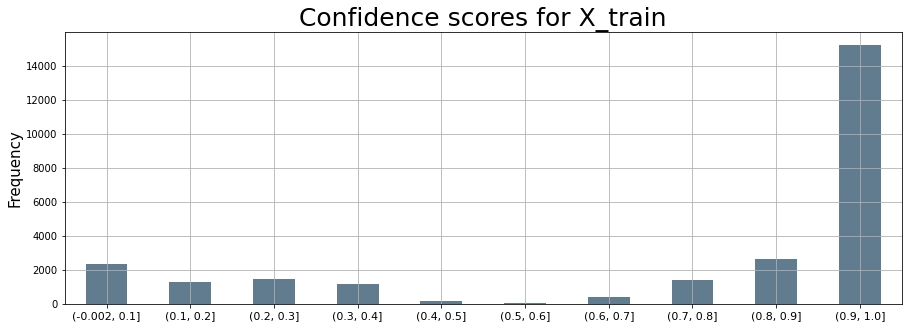

In [15]:
y_prob = clf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

In [16]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values

# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

In [17]:
top_c_lst 

[0.049, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [18]:
# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all 
X_train_pd = pd.DataFrame(X_train)
c = 0.95
    
# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 5
confidence_level = c
gen_lr = 2e-5
loss = 'log'


rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss,
                            confidence_levels=top_c_lst
                            )

print(f"Training CTGAN for c = {c}...")
hist = rf_ctgan.fit(train_data=z,
                    epochs=epochs,
                    gen_lr=gen_lr,
                    verbose=False
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()


print("\tGenerate samples to same dist...")
# Generate samples to same dist
samples = 100000
gen_data = rf_ctgan.sample(samples,top_c_lst[9])

Training CTGAN for c = 0.95...
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0
fakez

cuda:0
fakez

cuda:0
conf

cuda:0

In [19]:
#@title Example form fields
#@markdown Forms support many types of fields.

no_type_checking = ''  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 142  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


In [20]:
gen_data

,0,1,2,3,4,5
0,-1.176240,1.001037,-0.343113,1.813181,-1.348034,1.099612
1,1.094852,1.599307,0.378170,1.150327,0.793458,-1.006381
2,-0.834941,1.927030,0.255295,0.575884,-1.961036,-1.137599
3,-0.107857,0.327971,-1.122730,1.357347,1.344222,-0.727685
4,-0.794940,1.043425,0.003841,1.278807,-1.679862,-2.103530
...,...,...,...,...,...,...
99995,-0.269594,-0.040690,0.462051,0.845910,0.302617,0.543840
99996,1.109032,-0.648881,0.517542,1.107494,-0.014831,-0.321831
99997,-0.499851,-0.450594,-0.699624,0.225981,1.508691,-0.468206
99998,-0.404251,-0.027572,0.491362,1.818870,-0.981488,1.966849


In [21]:
y_prob = rf.predict_proba(gen_data)
y_conf_gen = y_prob[:, 0]  # confidence scores

# ans is the indices of gen_data to make the same dist 
ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
gen_data_same_dist = gen_data.iloc[ans]
y_conf_gen_same_dist = y_conf_gen[ans]

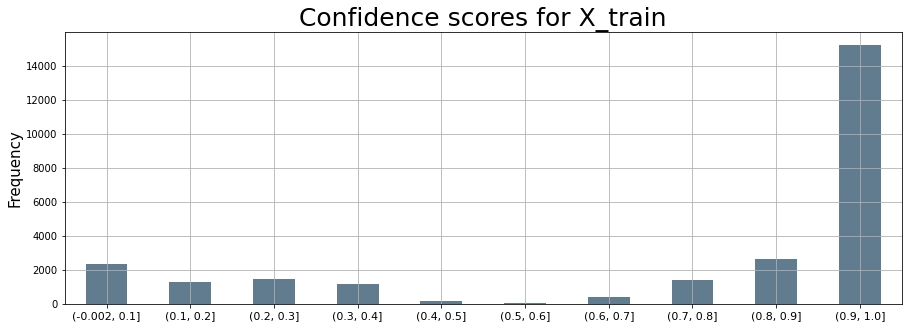

In [22]:
plot_confidence_levels(y_conf_gen_same_dist, "Confidence scores for X_train")

In [23]:
# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
gen_data_inv = pd.DataFrame(gen_data_inv)

In [25]:
# y_conf_gen_same_dist, gen_data_inv what we want
# results
# E. Calculate coverage for each similarity and conf diff thresholds
print(f"\tWorking on results...")
results,coverage, precision = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)
print(f"\tResults for confidence level = {c}")
display(results)

	Working on results...
	Results for confidence level = 0.95


,0.01,0.05,0.10,0.15,0.20
0.80,99.8733 | 0.4837,99.9347 | 0.4837,100.0 | 0.4837,100.0 | 0.4837,100.0 | 0.4837
0.85,99.8196 | 0.4069,99.8464 | 0.4069,100.0 | 0.4069,100.0 | 0.4069,100.0 | 0.4069
0.90,99.689 | 0.3225,99.7236 | 0.3225,99.9962 | 0.3225,100.0 | 0.3225,100.0 | 0.3225
0.95,99.5048 | 0.2188,99.5048 | 0.2227,99.7505 | 0.2227,99.7505 | 0.2227,99.7505 | 0.2227
0.99,98.856 | 0.0998,98.856 | 0.0998,99.4088 | 0.0998,99.4088 | 0.0998,99.4088 | 0.0998
